# Introduction
In this kernel I will go through alomst all the machine learning and deep learning ways to complete any NLP task. Here I will be using spam classifier example in which we have to determine whether the message is spam or not.

# Table of Contents
* Importing Libraries
* Reading the data
* Exploratory Data Analysis
* Data Cleaning
* Deep Learning Models

# Importing Libraries

In [1]:
import numpy as np
import pandas as pd 
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import train_test_split

from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Flatten, Dropout, SimpleRNN, Bidirectional
from keras.optimizers import Adam

# Reading the data

In [2]:
df = pd.read_csv('spam-text-message-classification/SPAM text message 20170820 - Data.csv')
df.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  5572 non-null   object
 1   Message   5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


# Exploratory Data Analysis

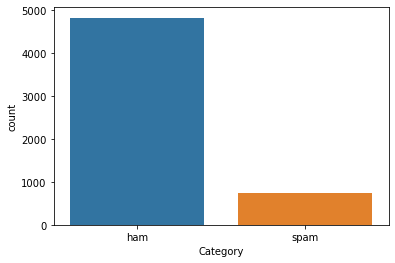

In [4]:
sns.countplot(x='Category', data = df)

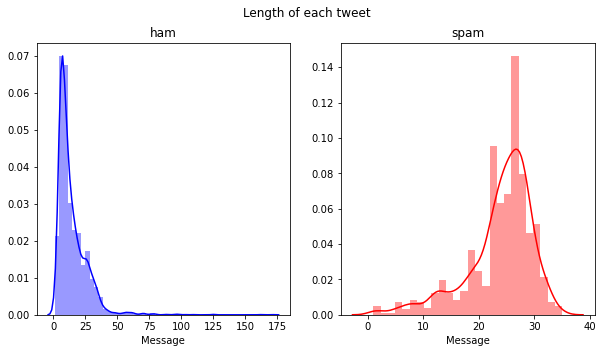

In [5]:
#length of a tweet
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
word=df[df['Category']=='ham']['Message'].str.split().map(lambda x : len(x))
sns.distplot(word,ax=ax1,color='blue')
ax1.set_title('ham')
word=df[df['Category']=='spam']['Message'].str.split().map(lambda x : len(x))
sns.distplot(word,ax=ax2,color='red')
ax2.set_title('spam')
fig.suptitle('Length of each tweet')
plt.show()

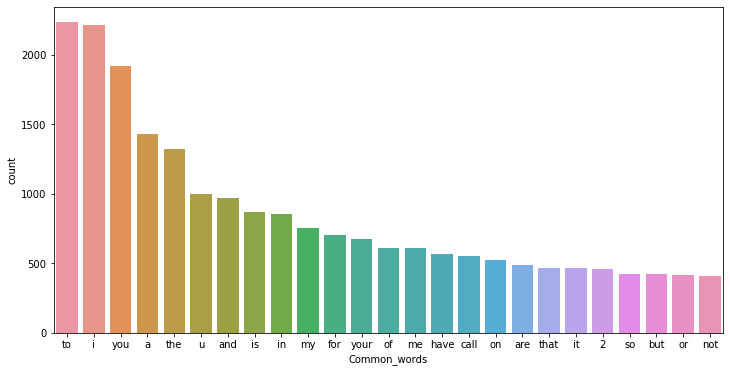

In [6]:
#Displaying most common words
df['temp_list'] = df['Message'].apply(lambda x : str(x).lower().split())
fig, axes = plt.subplots(1, 1, figsize=(12, 6))
from collections import Counter
top = Counter([item for sublist in df['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(25))
temp.columns = ['Common_words', 'count']
sns.barplot(x=temp['Common_words'], y=temp['count'], ax=axes)
plt.show()

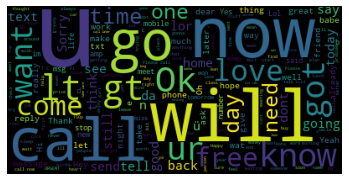

In [7]:
from wordcloud import WordCloud, STOPWORDS
text = df['Message'].values
cloud = WordCloud(stopwords = STOPWORDS,max_words = 200,).generate(" ".join(text))
plt.imshow(cloud)
plt.axis('off')
plt.show()

In [8]:
ps = PorterStemmer()

# Data Cleaning

In [9]:
def clean(text):
    text = re.sub('[^a-zA-Z]', ' ', text).lower().split()
    return text

In [10]:
df['Message'] = df['Message'].apply(lambda x : clean(x))

In [11]:
def stemming(text):
    text = [ps.stem(word) for word in text if not word in stopwords.words('english')]
    text = ' '.join(text)
    return text

In [12]:
df['Message'] = df['Message'].apply(lambda x : stemming(x))

In [13]:
y = pd.get_dummies(df['Category'])

In [14]:
y=y.iloc[:,1].values

In [15]:
X = df['Message'].values
X

array(['go jurong point crazi avail bugi n great world la e buffet cine got amor wat',
       'ok lar joke wif u oni',
       'free entri wkli comp win fa cup final tkt st may text fa receiv entri question std txt rate c appli',
       ..., 'piti mood suggest',
       'guy bitch act like interest buy someth els next week gave us free',
       'rofl true name'], dtype=object)

# Deep Learning Models

In [16]:
#Dictionary size
vocab_size=5000

In [17]:
epochs = 5 #Train for 20 epochs for better accuracy
batch_size = 32

In [18]:
encoded_docs = [one_hot(word, vocab_size) for word in X]

In [19]:
max_len = len(X.max())
pad_docs = pad_sequences(encoded_docs, maxlen = max_len, padding='post')

In [20]:
X_train, X_test, y_train, y_test = train_test_split(pad_docs, y, test_size = 0.20, random_state=3) 

## Simple RNN Model

In [21]:
model1 = Sequential()
model1.add(Embedding(vocab_size, 100, input_length = max_len))
model1.add(Dropout(0.2))
model1.add(SimpleRNN(100, return_sequences=True))
model1.add(Dropout(0.2))
model1.add(SimpleRNN(100, return_sequences=True))
#model1.add(Flatten())
model1.add(Dense(1024, activation='relu'))
model1.add(Dropout(0.2))
model1.add(Dense(1024, activation='relu'))
model1.add(Dropout(0.2))
model1.add(Dense(1, activation='sigmoid'))

In [22]:
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 73, 100)           500000    
_________________________________________________________________
dropout (Dropout)            (None, 73, 100)           0         
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 73, 100)           20100     
_________________________________________________________________
dropout_1 (Dropout)          (None, 73, 100)           0         
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 73, 100)           20100     
_________________________________________________________________
dense (Dense)                (None, 73, 1024)          103424    
_________________________________________________________________
dropout_2 (Dropout)          (None, 73, 1024)          0

In [23]:
model1.compile(optimizer='Adam', loss = 'binary_crossentropy', metrics=['acc'])

In [24]:
model1.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size)

Epoch 1/5
140/140 [==============================] - 33s 236ms/step - loss: 0.3076 - acc: 0.8951 - val_loss: 0.1725 - val_acc: 0.9582
Epoch 2/5
140/140 [==============================] - 33s 235ms/step - loss: 0.1634 - acc: 0.9594 - val_loss: 0.1601 - val_acc: 0.9604
Epoch 3/5
140/140 [==============================] - 32s 229ms/step - loss: 0.1646 - acc: 0.9528 - val_loss: 0.2523 - val_acc: 0.8610
Epoch 4/5
140/140 [==============================] - 33s 233ms/step - loss: 0.1589 - acc: 0.9353 - val_loss: 0.1815 - val_acc: 0.9435
Epoch 5/5
140/140 [==============================] - 32s 229ms/step - loss: 0.0907 - acc: 0.9800 - val_loss: 0.1953 - val_acc: 0.9568


## LSTM Model

In [25]:
model2 = Sequential()
model2.add(Embedding(vocab_size, 100, input_length = max_len))
model2.add(Dropout(0.2))
model2.add(LSTM(100, return_sequences = True))
model2.add(Dropout(0.2))
model2.add(LSTM(100, return_sequences = True))
#model2.add(Flatten())
model2.add(Dense(1024, activation='relu'))
model2.add(Dropout(0.2))
model2.add(Dense(1024, activation='relu'))
model2.add(Dropout(0.2))
model2.add(Dense(1, activation='sigmoid'))

In [26]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 73, 100)           500000    
_________________________________________________________________
dropout_4 (Dropout)          (None, 73, 100)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 73, 100)           80400     
_________________________________________________________________
dropout_5 (Dropout)          (None, 73, 100)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 73, 100)           80400     
_________________________________________________________________
dense_3 (Dense)              (None, 73, 1024)          103424    
_________________________________________________________________
dropout_6 (Dropout)          (None, 73, 1024)         

In [27]:
model2.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['acc'])

In [28]:
model2.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5, batch_size=32)

Epoch 1/5
140/140 [==============================] - 45s 318ms/step - loss: 0.2806 - acc: 0.9209 - val_loss: 0.1012 - val_acc: 0.9788
Epoch 2/5
140/140 [==============================] - 42s 303ms/step - loss: 0.0713 - acc: 0.9845 - val_loss: 0.0741 - val_acc: 0.9834
Epoch 3/5
140/140 [==============================] - 42s 303ms/step - loss: 0.0572 - acc: 0.9877 - val_loss: 0.0984 - val_acc: 0.9794
Epoch 4/5
140/140 [==============================] - 43s 304ms/step - loss: 0.0432 - acc: 0.9900 - val_loss: 0.1377 - val_acc: 0.9812
Epoch 5/5
140/140 [==============================] - 43s 305ms/step - loss: 0.0251 - acc: 0.9932 - val_loss: 0.1515 - val_acc: 0.9760


## Bidirectional RNN Model

In [29]:
model3 = Sequential()
model3.add(Embedding(vocab_size, 100, input_length = max_len))
model3.add(Dropout(0.2))
model3.add(Bidirectional(LSTM(100, return_sequences = True)))
model3.add(Dropout(0.2))
model3.add(Bidirectional(LSTM(100, return_sequences = True)))
model3.add(Dense(1024, activation='relu'))
model3.add(Dropout(0.2))
model3.add(Dense(1024, activation='relu'))
model3.add(Dropout(0.2))
model3.add(Dense(1, activation='sigmoid'))

In [30]:
model3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 73, 100)           500000    
_________________________________________________________________
dropout_8 (Dropout)          (None, 73, 100)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 73, 200)           160800    
_________________________________________________________________
dropout_9 (Dropout)          (None, 73, 200)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 73, 200)           240800    
_________________________________________________________________
dense_6 (Dense)              (None, 73, 1024)          205824    
_________________________________________________________________
dropout_10 (Dropout)         (None, 73, 1024)         

In [31]:
model3.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['acc'])

In [32]:
model3.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5, batch_size=32)

Epoch 1/5
140/140 [==============================] - 53s 377ms/step - loss: 0.2579 - acc: 0.9160 - val_loss: 0.1529 - val_acc: 0.9353
Epoch 2/5
140/140 [==============================] - 52s 371ms/step - loss: 0.1374 - acc: 0.9491 - val_loss: 0.0554 - val_acc: 0.9863
Epoch 3/5
140/140 [==============================] - 52s 370ms/step - loss: 0.0312 - acc: 0.9919 - val_loss: 0.1095 - val_acc: 0.9795
Epoch 4/5
140/140 [==============================] - 52s 368ms/step - loss: 0.0176 - acc: 0.9962 - val_loss: 0.0759 - val_acc: 0.9871
Epoch 5/5
140/140 [==============================] - 51s 368ms/step - loss: 0.0170 - acc: 0.9973 - val_loss: 0.0903 - val_acc: 0.9857
